# Using AWS Lambda and PyWren for Landsat 8 Time Series

This notebook is a simple demonstration of drilling a timeseries of [NDVI](https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index) values from the [Landsat 8 satellite images held on AWS](https://landsatonaws.com/). You can view these [time series of satellite images interactively](https://search.remotepixel.ca/#7.43/41.788/-88.447) as well, if you would like to see what they look like.

The code relies on the l8_ndvi_point function from the [remotepixel-api](https://github.com/RemotePixel/remotepixel-api) to compute an NDVI value for a given set of coordinates. It's recommended that you install this yourself, but currently a version of the API is accepting requests at the URL in the code below, and we will use this API (which is an AWS Lambda function) for the sake of this demo. It works by sending a request to an endpoint with a sceneID and a location like this:  
[https://w5xm4e5886.execute-api.us-west-2.amazonaws.com/production/l8_ndvi_point?coords=-87.596890,41.7856533&scene=LC08_L1TP_023031_20191007_20191018_01_T1](https://w5xm4e5886.execute-api.us-west-2.amazonaws.com/production/l8_ndvi_point?coords=-87.596890,41.7856533&scene=LC08_L1TP_023031_20191007_20191018_01_T1)  
This will return:
`{"ndvi": 0.21664535999298096, "date": "2019-10-07", "cloud": 0.07}` 

If you haven't already, please [install/configure PyWren](http://pywren.io/pages/gettingstarted.html) in order to run this notebook. We will be using [PyWren](https://github.com/pywren/pywren) to call the Remote Pixel API in parallel on satellite images that were taken over the past seven years, calculating a single NDVI value for each image. The satellite images themselves are held in a public S3 bucket. Thus, we are taking advantage of two levels of serverless parallelism (see workflow below): one for the API calls and one for the calculations themselves.

Once we have the results back as a list of dictionaries, drawn from a timeseries of more than 100 images, we can simply plot the resulting timeseries or do further analysis. BUT, the points may well be cloud or cloud shadow contaminated. We haven’t done any cloud masking to the imagery, but we do have the scene metadata on the probable amount of cloud across the entire scene. We use this to weight a [smoothing spline](https://docs.scipy.org/doc/scipy-0.19.1/reference/generated/scipy.interpolate.UnivariateSpline.html), such that an observation with no reported cloud over the scene has full weight, and an observation with a reported 100% of the scene with cloud has zero weight.  

<img src="pywren_workflow.png" width="800">

Original Code Credit: Peter Scarth (Joint Remote Sensing Research Program)

In [17]:
import requests, json, numpy, datetime
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
import pywren

# Function to return a Landsat 8 scene list given a Longitude,Latitude string
# This uses the amazing developmentseed Satellite API
# https://github.com/sat-utils/sat-api
def getSceneList(lonLat):
    scenes=[]
    url = "https://api.developmentseed.org/satellites/landsat"
    params = dict(
        contains=lonLat,
        satellite_name="landsat-8",
        limit="1000") 
    # Call the API to grab the scene metadata
    sceneMetaData = json.loads(requests.get(url=url, params=params).content)
    # Parse the metadata
    for record in sceneMetaData["results"]:
        scene = str(record['aws_index'].split('/')[-2]) 
        if scene[-2:] == '01':
            scene = scene[:-2] + '00'
        if scene[-2:] == '02':
            scene = scene[:-2] + '00'
        if scene[-2:] == '03':
            scene = scene[:-2] + '02'
        scenes.append(scene)   
    return scenes


# Function to call a AWS Lambda function to drill a single pixel and compute the NDVI
def getNDVI(scene):
    url = "https://w5xm4e5886.execute-api.us-west-2.amazonaws.com/production/l8_ndvi_point"
    params = dict(
        coords=lonLat,
        scene=scene)
    # Call the API and return the JSON results
    resp = requests.get(url=url, params=params)
    return json.loads(resp.text)


Let's compute the NDVI time series for the home of the MACSS program, [1155 E. 60th Street, Chicago, IL](https://www.google.com/maps/place/41%C2%B047'08.4%22N+87%C2%B035'48.8%22W).

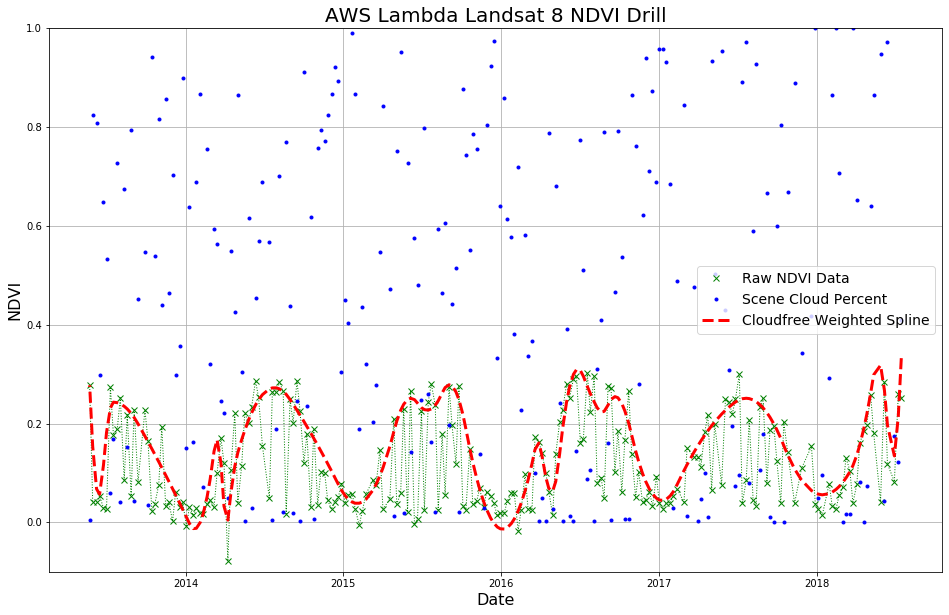

CPU times: user 4.7 s, sys: 1.55 s, total: 6.25 s
Wall time: 27 s


In [26]:
%%time

# 1155 E. 60th Street, Chicago, IL (Home of MACSS Program)
lonLat = '-87.596890,41.7856533'

# Call the api to retrieve the scenes available under the point of interest
scenes = getSceneList(lonLat)

# Set up a pywren executor and map the NDVI retrieval across all the available scenes
pwex = pywren.default_executor()
timeSeries = pywren.get_all_results(pwex.map(getNDVI, scenes))

# Extract the data trom the list of results
timeStamps = [datetime.datetime.strptime(obs['date'],'%Y-%m-%d') for obs in timeSeries if 'date' in obs]
ndviSeries = [obs['ndvi'] for obs in timeSeries if 'ndvi' in obs]
cloudSeries = [obs['cloud']/100 for obs in timeSeries if 'cloud' in obs]

# Create a time variable as the x axis to fit the observations
# First we convert to seconds
timeSecs = numpy.array([(obsTime-datetime.datetime(1970,1,1)).total_seconds() for obsTime in timeStamps])
# And then normalise from 0 to 1 to avoid any numerical issues in the fitting
fitTime = ((timeSecs-numpy.min(timeSecs))/(numpy.max(timeSecs)-numpy.min(timeSecs)))

# Smooth the data by fitting a spline weighted by cloud amount
smoothedNDVI=UnivariateSpline(
    fitTime[numpy.argsort(fitTime)],
    numpy.array(ndviSeries)[numpy.argsort(fitTime)],
    w=(1.0-numpy.array(cloudSeries)[numpy.argsort(fitTime)])**2.0,
    k=2,
    s=0.1)(fitTime)


# Setup the figure and plot the data, fit and cloud amount
fig = plt.figure(figsize=(16,10))
plt.plot(timeStamps,ndviSeries, 'gx',label='Raw NDVI Data')
plt.plot(timeStamps,ndviSeries, 'g:', linewidth=1)
plt.plot(timeStamps,cloudSeries, 'b.', linewidth=1,label='Scene Cloud Percent')
plt.plot(timeStamps,smoothedNDVI, 'r--', linewidth=3,label='Cloudfree Weighted Spline')
plt.xlabel('Date', fontsize=16)
plt.ylabel('NDVI', fontsize=16)
plt.title('AWS Lambda Landsat 8 NDVI Drill', fontsize=20)
plt.grid(True)
plt.ylim([-.1,1.0])
plt.legend(fontsize=14)
plt.show()
#plt.savefig('lambdaNDVI.png', bbox_inches='tight')